# Einführungsbeispiel - Zweifeldträger

Das Vorlesungsbeispiel verfolgt das Ziel, die Verformungen eines Zweifeldträgers für zwei Betonstähle mit unterschiedlichen Duktilitätsklassen aufzuzeigen. @jager_stahlbeton_2009.

![Statisches System des Zweifeldträgers mit Abmessungen versehen, daneben der Querschnitt mit Angaben zu der Längsbewehrung](../imgs/zweifeld_system.png){#fig-zweifeld_system}

Zunächst wird die analytische Lösung vollumfänglich dargestellt und mit numerischen Werten substituiert. Abschliessend wird das Verformungsverhalten mit dem Federmodell nachmodelliert, bzw. numerisch approximiert.

## Allgemeines

### Annahmen

- Zwei unterschiedliche Stähle
- konstant gerissene Biegesteifigkeit entlang der Stabachse

### Parameter



In [1]:
from packages import *

#### Bewehrung

In [2]:
# Längsbewehrung in X-Richtung gerichtet
diam_x = 14 * un.mm

# Teilung der Längsbewehrung
s_x = 200 * un.mm

# Längsbewehrung in Y-Richtung gerichtet
diam_y = 12 * un.mm

# Teilung der Längsbewehrung
s_y = 200 * un.mm

put_out(symbolic=False)

$$
\begin{aligned}
\oslash_{x}& = 14 \ \mathrm{mm} \quad & s_{x}& = 200 \ \mathrm{mm} \quad & \oslash_{y}& = 12 \ \mathrm{mm} \\ 
s_{y}& = 200 \ \mathrm{mm} \quad &  \quad &  
 \end{aligned}
$$

In [3]:
# Querschnittsfläche der Längsbewehrung, pro Längeneinheit
a_s = (diam_x**2 / 4 * np.pi / s_x).to(un.mm**2 / un.m)

put_out(symbolic=True)

$$
\begin{aligned}
a_{s}& = \frac{\pi \cdot \oslash_{x}^{2}}{4 \cdot s_{x}} = 769.69 \ \frac{\mathrm{mm}^{2}}{\mathrm{m}} \quad &  \quad &  
 \end{aligned}
$$

#### Geometrie

In [4]:
# Betonüberdeckung
c = 20 * un.mm

# Plattenstärke
h = 300 * un.mm

# Streifenbreite
b_w = 1 * un.m

# Balkenlänge
l = 8 * un.m


put_out()

$$
\begin{aligned}
c& = 20 \ \mathrm{mm} \quad & h& = 300 \ \mathrm{mm} \quad & b_{w}& = 1 \ \mathrm{m} \\ 
l& = 8 \ \mathrm{m} \quad &  \quad &  
 \end{aligned}
$$

In [5]:
# Statische Höhe in der Bewehrung in X-Richtung
d_x = h - c - diam_y - 1 / 2 * diam_x

put_out(symbolic=True)

$$
\begin{aligned}
d_{x}& = - \frac{1 \cdot \oslash_{x}}{2} - \oslash_{y} - c + h = 261.0 \ \mathrm{mm} \quad &  \quad &  
 \end{aligned}
$$

#### Beton

In [6]:
# Zylinderdruckfestigkeit vorausgesetzt
f_cc = 30 * un.N / un.mm**2

# Elastizitätsmodul des Betons
E_c = 29.3 * un.kN / un.mm**2

# Bruchstauchung Erfahrungswert
varepsilon_cu = 5 * un.permille

put_out()


$$
\begin{aligned}
f_{cc}& = 30.0 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \quad & E_{c}& = 29.3 \ \frac{\mathrm{kN}}{\mathrm{mm}^{2}} \quad & \varepsilon_{cu}& = 5 \ \mathrm{‰} \end{aligned}
$$

In [7]:
# Betonzugfestigkeit, nicht einheitentreu
f_ct = (0.3 * f_cc.m ** (2 / 3)) * un.N / un.mm**2

# Effektive Betondruckfestigkeit, nicht einheitentreu
f_c = (2.5 * f_cc.m ** (2 / 3)) * un.N / un.mm**2


put_out(symbolic=True, evaluate=False, rows=1)

$$
\begin{aligned}
f_{ct}& = 0.3 \cdot f_{cc}^{\frac{2}{3}} = 2.9 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \\ 
f_{c}& = 2.5 \cdot f_{cc}^{\frac{2}{3}} = 24.14 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \end{aligned}
$$

### Modellbildung - Zuggurtmodell

In [8]:
# Verbundschubspannung vor dem Fliessen
tau_b0 = 2 * f_ct

# Verbundschubspannung vor dem Fliessen
tau_b1 = f_ct

put_out(symbolic=True, rows=1)

$$
\begin{aligned}
\tau_{b0}& = 2 \cdot f_{ct} = 5.79 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \\ 
\tau_{b1}& = f_{ct} = 2.9 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \end{aligned}
$$

In [9]:
# Abschätzung der mitwirkenden Höhe der Betonzugzone
h_eff = 2 * (h - d_x)

# Geometrischer Bewehrungsgehalt
rho = (a_s / h_eff).to(un.percent)

put_out(symbolic=True, rows=1)

$$
\begin{aligned}
h_{eff}& = 2 \cdot \left(- d_{x} + h\right) = 78.0 \ \mathrm{mm} \\ 
\rho& = \frac{a_{s}}{h_{eff}} = 0.99 \ \mathrm{\%} \end{aligned}
$$

In [10]:
# maximaler Rissabstand
s_r0 = (diam_x * (1 - rho) / (4 * rho)).to(un.mm)

# minimaler Rissabstand
s_rl = 1 / 2 * s_r0

put_out(symbolic=True, rows=1)

$$
\begin{aligned}
s_{r0}& = \frac{\oslash_{x} \cdot \left(1 - \rho\right)}{4 \cdot \rho} = 351.19 \ \mathrm{mm} \\ 
s_{rl}& = 1 \cdot \frac{1}{2} \cdot s_{r0} = 175.59 \ \mathrm{mm} \end{aligned}
$$

In [11]:
# Annahme des Rissabstandes, entspricht dem Abstand der Querstäbe
s_r = 200 * un.mm

put_out()

$$
\begin{aligned}
s_{r}& = 200 \ \mathrm{mm} \quad &  \quad &  
 \end{aligned}
$$

In [12]:
# Bestimmung der mittleren Stahldehnung

def varepsilon_sm_bilinear(
    E_s, E_sh, s_r, tau_b0, tau_b1, diam, sigma_sr, f_sy, f_su, epsilon_sy
):
    display(Markdown("Berechnungen nach @marti_tragverhalten_1999 Seite 156"))
    if sigma_sr <= f_sy:
        display(Markdown("Gleichung 1"))
        return sigma_sr / E_s - tau_b0 * s_r / (E_s * diam)

    if f_sy <= sigma_sr <= (f_sy + (2 * tau_b1 * s_r) / diam):
        display(Markdown("Gleichung 2"))
        return (
            (sigma_sr - f_sy) ** 2
            * diam
            / (4 * E_sh * tau_b1 * s_r)
            * (1 - E_sh * tau_b0 / (E_s * tau_b1))
            + (sigma_sr - f_sy) / E_s * tau_b0 / tau_b1
            + (epsilon_sy - tau_b0 * s_r / (E_s * diam))
        )

    if (f_sy + 2 * tau_b1 * s_r / diam) <= sigma_sr <= f_su:
        display(Markdown("Gleichung 3"))
        return (sigma_sr - f_sy) / E_sh + (epsilon_sy - tau_b1 * s_r / (E_sh * diam))
    

# Extending the function to include the equations from Fall B (D.6 to D.10).
def varepsilon_sm_trilinear(sigma_max, f_sy, f_sh, fsu, E_s, E_sh1, E_sh2, tau_b0, tau_b1, tau_b2, diam, s_rm, epsilon_sy, epsilon_sh):
    # Fall A (D.1 to D.5) logic remains the same:
    # Equation D.1: for σ_max ≤ f_sy
    if (f_sh - f_sy)*diam/(4*tau_b1) > s_r/2:
        display(Markdown(f"Da $f_{{sh}}-f_{{sy}} * \\frac{{\\oslash}}{{4\cdot \\tau_{{b1}}}} = {(f_sh - f_sy) * diam /(4*tau_b1)} \geq \\frac{{s_r}}{{2}} = {s_r/2}$ gilt, wird nach @alvarez_einfluss_1998 Seite 163 Fall A gerechnet"))
        if sigma_max <= f_sy:
            display(Markdown("Gleichung 1"))
            esm = (sigma_max / E_s) - (tau_b0 * s_rm) / (E_s * diam)
            return esm
        
        # Equation D.2: for f_sy < σ_max ≤ (f_sy + τ_b1 * s_rm / Ø)
        elif f_sy < sigma_max <= (f_sy + (tau_b1 * s_rm / diam)):
            display(Markdown("Gleichung 2"))
            term1 = (sigma_max - f_sy)**2 * diam / (4 * E_sh1 * tau_b1 * s_rm)
            term2 = (1 - (E_sh1 * tau_b0) / (E_s * tau_b1)) * tau_b0 / E_s
            term3 = epsilon_sy - (tau_b0 * s_rm) / (E_s * diam)
            esm = term1 + term2 + term3
            return esm
        
        # Equation D.3: for (f_sy + τ_b1 * s_rm / Ø) < σ_max ≤ f_sh
        elif (f_sy + (tau_b1 * s_rm / diam)) < sigma_max <= f_sh:
            display(Markdown("Gleichung 3"))
            esm = ((sigma_max - f_sy) / E_sh1) + epsilon_sy - (tau_b1 * s_rm) / (E_sh1 * diam)
            return esm
        
        # Equation D.4: for f_sh < σ_max ≤ (f_sh + τ_b2 * s_rm / Ø)
        elif f_sh < sigma_max <= (f_sh + (tau_b2 * s_rm / diam)):
            display(Markdown("Gleichung 4"))
            term1 = (sigma_max - f_sh)**2 * diam / (4 * E_sh2 * tau_b2 * s_rm)
            term2 = (1 - (E_sh2 * tau_b1) / (E_sh1 * tau_b2)) * tau_b1 / E_s
            term3 = epsilon_sy - (tau_b2 * s_rm) / (E_sh2 * diam)
            esm = term1 + term2 + term3
            return esm
        
        # Equation D.5: for (f_sh + 2 * τ_b2 * s_rm / Ø) ≤ σ_max ≤ f_su
        elif (f_sh + (2 * tau_b2 * s_rm / diam)) <= sigma_max <= fsu:
            display(Markdown("Gleichung 5"))
            esm = ((sigma_max - f_sh) / E_sh2) + epsilon_sy - (tau_b2 * s_rm) / (E_sh2 * diam)
            return esm
    
    elif (f_sh - f_sy)*diam/(4*tau_b1) <=s_r/2:
        display(Markdown(f"Da $f_{{sh}}-f_{{sy}} \cdot \\frac{{\\oslash}}{{4\cdot \\tau_{{b1}}}} = {(f_sh - f_sy) * diam /(4*tau_b1)} \leq \\frac{{s_r}}{{2}} = {s_r/2}$ gilt, wird nach @alvarez_einfluss_1998 Seite 163 Fall B gerechnet"))
        # Fall B (D.6 to D.10) logic:
        # Equation D.6: for σ_max ≤ f_sy
        if sigma_max <= f_sy:
            display(Markdown("Gleichung 1"))
            esm = (sigma_max / E_s) - (tau_b0 * s_rm) / (E_s * diam)
            return esm

        # Equation D.7: for f_sy < σ_max ≤ f_sh
        elif f_sy < sigma_max <= f_sh:
            display(Markdown("Gleichung 2"))
            term1 = ((sigma_max - f_sy)**2 * diam) / (4 * E_sh1 * tau_b1 * s_rm)
            term2 = (1 - E_sh1 * tau_b0 / (E_s * tau_b1)) * tau_b0 / E_s
            term3 = (sigma_max - f_sy) * tau_b0 / (E_s * tau_b1)
            term4 = epsilon_sy - tau_b0 * s_rm / (E_s * diam)
            esm = term1 + term2 + term3 + term4
            return esm
        
        # Equation D.8: for f_sh ≤ σ_max ≤ (f_sh + τ_b2 * s_rm / Ø)
        elif f_sh <= sigma_max <= (f_sh + 2 * tau_b2 * s_rm / diam - (f_sh - f_sy) * tau_b2 / tau_b1):
            display(Markdown("Gleichung 3"))
            term1 = (sigma_max - f_sh)**2 * diam / (4 * E_sh2 * tau_b2 * s_rm)
            term2 = (1 - (E_sh2 * tau_b0) / (E_s * tau_b1)) * tau_b0 / E_s
            term3 = (sigma_max - f_sh) * tau_b1 / (E_s * tau_b2)
            term4 = (epsilon_sy - epsilon_sh) / 2 * tau_b2 / tau_b1
            term5 = (epsilon_sy - tau_b0 * s_rm / (E_s * diam)) * tau_b0 / tau_b1
            esm = term1 + term2 + term3 + term4 + term5
            return esm
        
        # Equation D.9: for f_sh + τ_b2 * s_rm / Ø ≤ σ_max ≤ f_su
        elif (f_sh + 2 * tau_b2 * s_rm / diam - (f_sh - f_sy) * tau_b2 / tau_b1) <= sigma_max <= fsu:
            display(Markdown("Gleichung 4"))
            term1 = (sigma_max - f_sh)**2 * diam / (4 * E_sh2 * tau_b2 * s_rm)
            term2 = (1 - E_sh2 * tau_b1 / (E_sh1 * tau_b2)) * tau_b1 / E_s
            term3 = (sigma_max - f_sh) * tau_b1 / E_sh1
            term4 = (epsilon_sy - tau_b2 * s_rm / (E_sh2 * diam)) * tau_b2 / tau_b1
            esm = term1 + term2 + term3 + term4
            return esm
        
        # Equation D.10: for (f_sh + 2 * τ_b2 * s_rm / Ø) ≤ σ_max ≤ f_su
        elif (f_sh + 2 * tau_b2 * s_rm / diam) <= sigma_max <= fsu:
            display(Markdown("Gleichung 5"))
            esm = ((sigma_max - f_sh) / E_sh2) + epsilon_sh - (tau_b2 * s_rm) / (E_sh2 * diam)
            return esm
        
    # If none of the conditions are met, return an error.
    else:
        raise ValueError("σ_max is out of the valid range")

# This function is now extended to handle both Fall A and Fall B scenarios (D.1 to D.10).



### Plastischer Rotationswinkel

Der Plastische Roatationswinkel gibt die Rotation eines plastischen Gelenks voraus. 

![Modell zur Abschätzung der plastischen Rotation](../imgs/plast_rotation.png){#fig-plast_rot}

## Kaltverformter Betonstahl - B500A

### Eigenschaften des Betonstahls

Allgemein werden die Eigenschaften für den Betonstahl B500A mit einem Suffix $A$ gekennzeichnet.


In [13]:
# Fliessgrenze
f_sy_com_A = 570 * un.N / un.mm**2

# Zugfestigkeit
f_su_com_A = 600 * un.N / un.mm**2

# Fliessdehnung
varepsilon_sy_com_A = 2.78 * un.permille

# Bruchdehnung
varepsilon_su_com_A = 25 * un.permille

# Elastizitätsmodul
E_s_com_A = 205 * un.kN / un.mm**2

# Verfestigungsmodul
E_sh_com_A = 1350 * un.N / un.mm**2

put_out()

$$
\begin{aligned}
f_{sy , A}& = 570.0 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \quad & f_{su , A}& = 600.0 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \quad & \varepsilon_{sy , A}& = 2.78 \ \mathrm{‰} \\ 
\varepsilon_{su , A}& = 25 \ \mathrm{‰} \quad & E_{s , A}& = 205.0 \ \frac{\mathrm{kN}}{\mathrm{mm}^{2}} \quad & E_{sh , A}& = 1350.0 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \end{aligned}
$$

In [14]:
# | echo: false

stress_b500a_array = np.array([0, f_sy_com_A.m, f_su_com_A.m]) * un.MPa
strain_b500a_array = np.array([0, varepsilon_sy_com_A, varepsilon_su_com_A])

fig_b500a, ax_b500a = plt.subplots()
ax_b500a.plot(strain_b500a_array, stress_b500a_array.to(un.MPa).m, color="k")

# Scientific Notation if needed
apply_scientific_notation(ax_b500a, stress_b500a_array.m)

# Set axis labels
ax_b500a.set_ylabel(r"$\sigma$ [N/mm$^2$]")
ax_b500a.set_xlabel(r"$\varepsilon_s$ [-]")

# Set limits
ax_b500a.set_xlim(xmax=135 / 1000)
ax_b500a.set_ylim(ymax=750)

# Show the plot
# plt.tight_layout()
plt.savefig("imgs/jag_stress_strain_b500a.svg")
plt.close()

![Spannungs-Dehnungs-Beziehung des Betonstahls B500A](../imgs/jag_stress_strain_b500a_bearb.svg){#stress_strain_b500a}

### Linear elastische - gerissene Biegesteifigkeit

Wird fortan für sämtliche Verformungsberechnungen verwendet.
Querschnittsanalyse:


In [15]:
# Wertigkeit der Elastizitätsmodule
n = E_s_com_A / E_c

put_out(symbolic=True)

$$
\begin{aligned}
n& = \frac{E_{s , A}}{E_{c}} = 7.0 \  \quad &  \quad &  
 \end{aligned}
$$

Die Druckzonenhöhe wird mittels dem Gleichgewicht der horizontalen Kräfte ermittelt

In [16]:
# Mittels Sympy (CAS für Python) wird eine analytische Lösung der
# Druckzonenhöhe für den gerissenen Querschnitt ermittelt.

# Summe der horizontalen Kräfte
sum_Fx = sp.sympify("1/2*x*b_w*sigma_c -sigma_s*a_s*b_w")

# Definition der Spannung in Abhängigkeit der Dehnungen
expr_sigma_c = sp.sympify("varepsilon_c * E_c")
expr_sigma_s = sp.sympify("varepsilon_s * n * E_c")

# Die Beziehung zwischen der Stahl- und Betondehnung nach Hook
expr_epsilon_c = sp.sympify("varepsilon_s /(d-x)*x")

# Substitution der Gleichungen
sum_Fx_subs = sum_Fx.subs(
    {
        "sigma_c": expr_sigma_c.subs("varepsilon_c", expr_epsilon_c),
        "sigma_s": expr_sigma_s,
    }
)

# Erstellen einer numerischen Funktion
x_solve = sp.solve(sum_Fx_subs, "x")[1]
x_solve_lambd = sp.lambdify(("a_s", "b_w", "n", "d"), x_solve)

In [17]:
# Druckzonenhöhe mit Parametern substituiert
x_II = x_solve_lambd(a_s, b_w, n, d_x).to(un.mm)

put_out(symbolic=False)

$$
\begin{aligned}
x_{II}& = 47.91 \ \mathrm{mm} \quad &  \quad &  
 \end{aligned}
$$

In [18]:
# Flächenmoment 2. Grades für den Beton
I_cII = (b_w * x_II**3 / 12 + b_w * x_II * (x_II / 2) ** 2).to(un.mm**4)

# Flächenmoment 2. Grades für den Betonstahl
I_sII = (a_s * b_w * n * (d_x - x_II) ** 2).to(un.mm**4)

# Flächenmoment 2. Grades für den gerissenen Querschnitt
I_II = (I_cII + I_sII).to(un.mm**4)

put_out(symbolic=True, rows=1, evaluate=False)

$$
\begin{aligned}
I_{cII}& = \frac{b_{w} \cdot x_{II}^{3}}{12} + b_{w} \cdot x_{II} \cdot \left(\frac{x_{II}}{2}\right)^{2} = 36650532.72 \ \mathrm{mm}^{4} \\ 
I_{sII}& = a_{s} \cdot b_{w} \cdot n \cdot \left(d_{x} - x_{II}\right)^{2} = 244534349.46 \ \mathrm{mm}^{4} \\ 
I_{II}& = I_{cII} + I_{sII} = 281184882.18 \ \mathrm{mm}^{4} \end{aligned}
$$

In [19]:
# Gerissene Biegesteifigkeit
EI_II_com_A = (E_c * I_II).to(un.kN * un.m**2)

put_out(symbolic=True)

$$
\begin{aligned}
EI_{II , A}& = E_{c} \cdot I_{II} = 8238.72 \ \mathrm{kN} \cdot \mathrm{m}^{2} \quad &  \quad &  
 \end{aligned}
$$

### Hebelarm der inneren Kräfte

Der Hebelarm der inneren Kräfte wird für den gesamten Träger als konstant angenommen.
Dabei wird dem Beton die Zylinderdruckfestigkeit hinterlegt, sowie erreicht der Stahl die Zugfestigkeit. 

In [20]:
# Druckzonenhöhe für den Biegewiderstand
x_dv_com_A = (a_s * b_w * f_su_com_A / (0.85 * f_cc * b_w)).to(un.mm)

# Hebelarm der inneren Kräfte für den Biegewiderstand
d_v_com_A = d_x - 1 / 2 * 0.85 * x_dv_com_A 

# Biegewiderstand
m_u_com_A = (a_s * f_su_com_A * d_v_com_A).to(un.kNm / un.m)

put_out(symbolic=True, evaluate=False, rows=1)

$$
\begin{aligned}
x_{dv , A}& = \frac{a_{s} \cdot b_{w} \cdot f_{su , A}}{0.85 \cdot b_{w} \cdot f_{cc}} = 18.11 \ \mathrm{mm} \\ 
d_{v , A}& = d_{x} - 1 \cdot \frac{1}{2} \cdot 0.85 \cdot x_{dv , A} = 253.3 \ \mathrm{mm} \\ 
m_{u , A}& = a_{s} \cdot d_{v , A} \cdot f_{su , A} = 116.98 \ \frac{\mathrm{kNm}}{\mathrm{m}} \end{aligned}
$$

### Grenzzustände des Zugglieds

#### Risselement bei Fliessbeginn - Zustand $A1$

Zunächst wird ein Grenzzustand betrachtet, bei dem das Risselement gerade beim Fliessbeginn steht.

In [21]:
# Stahlspannungen
sigma_1_s_com_A1 = f_sy_com_A
sigma_2_s_com_A1 = f_sy_com_A - 4 * tau_b0 * s_r / 2 / diam_x


# Stahldehnungen
varepsilon_1_s_com_A1 = (sigma_1_s_com_A1 / E_s_com_A).to(un.permille)
varepsilon_2_s_com_A1 = (sigma_2_s_com_A1 / E_s_com_A).to(un.permille)

put_out(symbolic=True, rows=1)

$$
\begin{aligned}
\sigma_{1 s , A1}& = f_{sy , A} = 570.0 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \\ 
\sigma_{2 s , A1}& = f_{sy , A} - \frac{4 \cdot s_{r} \cdot \tau_{b0}}{2 \cdot \oslash_{x}} = 404.49 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \\ 
\varepsilon_{1 s , A1}& = \frac{\sigma_{1 s , A1}}{E_{s , A}} = 2.78 \ \mathrm{‰} \\ 
\varepsilon_{2 s , A1}& = \frac{\sigma_{2 s , A1}}{E_{s , A}} = 1.97 \ \mathrm{‰} \end{aligned}
$$

In [22]:
# Mittlere Stahldehnung nach 
varepsilon_m_s_com_A1 = varepsilon_sm_bilinear(E_s_com_A, E_sh_com_A, s_r, tau_b0, tau_b1, diam_x, f_sy_com_A, f_sy_com_A, f_su_com_A, varepsilon_sy_com_A).to(un.permille)

put_out()


Berechnungen nach @marti_tragverhalten_1999 Seite 156

Gleichung 1

$$
\begin{aligned}
\varepsilon_{m s , A1}& = 2.38 \ \mathrm{‰} \quad &  \quad &  
 \end{aligned}
$$

In [23]:
# Fliessmoment
m_y_com_A = (a_s * f_sy_com_A * d_v_com_A).to(un.kNm / un.m)

put_out(symbolic=True)

$$
\begin{aligned}
m_{y , A}& = a_{s} \cdot d_{v , A} \cdot f_{sy , A} = 111.13 \ \frac{\mathrm{kNm}}{\mathrm{m}} \quad &  \quad &  
 \end{aligned}
$$

In [24]:
# | echo: false


def plot_stress_strain(
    coordinates,
    filename,
    strain_mean=0,
    strain=False,
    stress=True,
):

    # Plot the polygon
    x, y = zip(*coordinates)  # Unzip the coordinates into x and y

    fig, ax = plt.subplots()

    if strain == True:
        stress = False
        y = np.array(y)*1000  # Convert to permille
        xlabel = r"$x$ [mm]"
        permille = '$10^{-3}$'
        ylabel = rf"$\varepsilon$ [{permille}]"
        
        # Append the first point to close the polygon
        x = np.append(x, x[0])
        y = np.append(y, y[0])

        # Plot the coordinates
        ax.plot(x, y, "black")
        ax.fill(x, y, color="darkgray", alpha=0.2)
        ax.axhline(strain_mean, linestyle='--', color = 'black')

    if stress == True:
        xlabel = r"$x$ [mm]"
        ylabel = r"$\sigma$ [N/mm$^2$]"
        
        # Append the first point to close the polygon
        x = np.append(x, x[0])
        y = np.append(y, y[0])

        # Plot the coordinates
        ax.plot(x, y, "black")


    # Add labels and show the plot
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    # Save the plot to the specified file
    plt.savefig(filename)
    plt.close()


In [25]:
# | echo: false

coords_a1_stress = [
    (0, 0),
    (s_r.m / 2, 0),
    (s_r.m / 2, sigma_2_s_com_A1.m),
    (0, sigma_1_s_com_A1.m),
]

plot_stress_strain(coords_a1_stress, "imgs/jag_stress_a1.svg", stress=True)


coords_a1_strain = [
    (0, 0),
    (s_r.m / 2, 0),
    (s_r.m / 2, varepsilon_2_s_com_A1),
    (0, varepsilon_1_s_com_A1),
]

plot_stress_strain(coords_a1_strain, "imgs/jag_strain_a1.svg", strain=True,strain_mean=varepsilon_m_s_com_A1.to(un.los))

::: {#fig-jag_zustand_a1 layout-ncol=2}
![Spannungsverlauf entlang des Zugglieds auf halbem Rissabstand](../imgs/jag_stress_a1.svg){#fig-jag_stress_a1}

![Dehnungsverlauf entlang des Zugglieds auf halbem Rissabstand](../imgs/jag_strain_a1.svg){#fig-jag_strain_a1}

Spannungs- und Dehnungsverlauf entlang der Hälfte des Rissabstands für den Zustand $A1$
:::

#### Risselement beim Erreichen der Zugfestigkeit - Zustand $A2$

Innerhalb des Risselements befindet sich der Betonstahl über der Fliessgrenze, sowohl bereichsweise unterhalb der Fliessgrenze. Dies führt zu den folgenden Spannungs- und Dehnungsverteilungen.

In [26]:
# Plastischer Bereich
Delta_x_pl_com_A2 = (f_su_com_A - f_sy_com_A) / (4 * tau_b1 / diam_x)

# Elastischer Bereich
Delta_x_el_com_A2 = s_r / 2 - Delta_x_pl_com_A2

put_out(symbolic=True, evaluate=False, rows=1)

$$
\begin{aligned}
\Delta_{x pl , A2}& = \frac{f_{su , A} - f_{sy , A}}{4 \cdot \frac{1}{\oslash_{x}} \cdot \tau_{b1}} = 36.25 \ \mathrm{mm} \\ 
\Delta_{x el , A2}& = - \Delta_{x pl , A2} + \frac{s_{r}}{2} = 63.75 \ \mathrm{mm} \end{aligned}
$$

In [27]:
# Stahlspannungen
sigma_3_s_com_A2 = f_sy_com_A - 4 * tau_b0 * Delta_x_el_com_A2 / diam_x
sigma_2_s_com_A2 = f_sy_com_A
sigma_1_s_com_A2 = f_sy_com_A + 4 * tau_b1 * Delta_x_pl_com_A2 / diam_x

# Stahldehnung
varepsilon_1_s_com_A2 = varepsilon_su_com_A
varepsilon_2_s_com_A2 = varepsilon_sy_com_A
varepsilon_3_s_com_A2 = (sigma_3_s_com_A2 / E_s_com_A).to(un.permille)

put_out(symbolic=True, rows=1, evaluate=False)

$$
\begin{aligned}
\sigma_{3 s , A2}& = - \frac{4 \cdot \Delta_{x el , A2} \cdot \tau_{b0}}{\oslash_{x}} + f_{sy , A} = 464.49 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \\ 
\sigma_{2 s , A2}& = f_{sy , A} = 570.0 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \\ 
\sigma_{1 s , A2}& = \frac{4 \cdot \Delta_{x pl , A2} \cdot \tau_{b1}}{\oslash_{x}} + f_{sy , A} = 600.0 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \\ 
\varepsilon_{1 s , A2}& = \varepsilon_{su , A} = 25 \ \mathrm{‰} \\ 
\varepsilon_{2 s , A2}& = \varepsilon_{sy , A} = 2.78 \ \mathrm{‰} \\ 
\varepsilon_{3 s , A2}& = \frac{\sigma_{3 s , A2}}{E_{s , A}} = 2.27 \ \mathrm{‰} \end{aligned}
$$

In [28]:
# Mittlere Stahldehnung
varepsilon_m_s_com_A2 = varepsilon_sm_bilinear(
    E_s_com_A, E_sh_com_A, s_r, tau_b0, tau_b1, diam_x, f_su_com_A, f_sy_com_A, f_su_com_A, varepsilon_sy_com_A
).to(un.permille)

put_out()

Berechnungen nach @marti_tragverhalten_1999 Seite 156

Gleichung 2

$$
\begin{aligned}
\varepsilon_{m s , A2}& = 6.64 \ \mathrm{‰} \quad &  \quad &  
 \end{aligned}
$$

In [29]:
# | echo: false

coords_A2_stress = [
    (0, 0), 
    (Delta_x_pl_com_A2.m, 0), 
    (s_r.m / 2, 0), 
    (s_r.m / 2, sigma_3_s_com_A2.m), 
    (Delta_x_pl_com_A2.m, sigma_2_s_com_A2.m),
    (0, sigma_1_s_com_A2.m)
    ]

plot_stress_strain(coords_A2_stress, "imgs/jag_stress_a2.svg", stress=True)


coords_Z2_strain = [
    (0, 0),
    (Delta_x_pl_com_A2.m, 0),
    (s_r.m / 2, 0),
    (s_r.m / 2, varepsilon_3_s_com_A2),
    (Delta_x_pl_com_A2.m, varepsilon_2_s_com_A2),
    (0, varepsilon_1_s_com_A2),
]

plot_stress_strain(coords_Z2_strain, "imgs/jag_strain_a2.svg", strain=True)

::: {#fig-jag_zustand_a2 layout-ncol=2}
![Spannungsverlauf entlang des Zugglieds auf halbem Rissabstand](../imgs/jag_stress_a2.svg){#fig-jag_stress_a2}

![Dehnungsverlauf entlang des Zugglieds auf halbem Rissabstand](../imgs/jag_strain_a2.svg){#fig-jag_strain_a2}

Spannungs- und Dehnungsverlauf entlang der Hälfte des Rissabstands für den Zustand $A2$
:::

### Systemanalyse 

Nun wird das System analysiert, sprich der Zweifeldträger.

#### Fliessen des Mittelauflagers - Zustand $SA1$

In [30]:
# Die Streckenlast zum Erreichen des Fliessens bei B
q_SA1 = (8 * m_y_com_A*b_w / l**2).to(un.kN/un.m)

# maximale Verformung im Feld 
w_SA1 = (5 * q_SA1 * l**4 / (384 * EI_II_com_A) - m_y_com_A*b_w * l**2 / (16 * EI_II_com_A)).to(un.mm)

put_out(symbolic=True, evaluate=False, rows=1)

$$
\begin{aligned}
q_{SA1}& = \frac{8 \cdot b_{w} \cdot m_{y , A}}{l^{2}} = 13.89 \ \frac{\mathrm{kN}}{\mathrm{m}} \\ 
w_{SA1}& = \frac{5 \cdot l^{4} \cdot q_{SA1}}{384 \cdot EI_{II , A}} - \frac{b_{w} \cdot l^{2} \cdot m_{y , A}}{16 \cdot EI_{II , A}} = 35.97 \ \mathrm{mm} \end{aligned}
$$

#### Fliessbeginn im Feld - Zustand $SA2$

![Fliessen im Feld](../imgs/jag_fliessen_feld.png)

In [31]:
# Streckenlast beim Fliessbeginn im Feld
q_SA2 = (((4 * m_y_com_A + 2 * m_u_com_A) / l**2 + 4 / l**2 * np.sqrt(m_y_com_A**2 + m_y_com_A * m_u_com_A))*b_w).to(un.kN/un.m)

put_out(symbolic=True, evaluate=False, rows=1)

$$
\begin{aligned}
q_{SA2}& = b_{w} \cdot \left(\frac{2 \cdot m_{u , A} + 4 \cdot m_{y , A}}{l^{2}} + \frac{4 \cdot \sqrt{m_{u , A} \cdot m_{y , A} + m_{y , A}^{2}}}{l^{2}}\right) = 20.55 \ \frac{\mathrm{kN}}{\mathrm{m}} \end{aligned}
$$

##### Kontrolle der Duktilität

In [32]:
# Rotationswinkel (Verwendung der Arbeitsgleichung)
alpha_SA2 = ((q_SA2 - q_SA1) * l**3 / (24 * EI_II_com_A) - (m_u_com_A - m_y_com_A) * b_w * l / (3 * EI_II_com_A)).to(un.deg)

# Verformungsbedarf
Theta_SA2_com_erf = 2 * alpha_SA2


put_out(symbolic=True, evaluate=False, rows=1)

$$
\begin{aligned}
\alpha_{SA2}& = \frac{l^{3} \cdot \left(- q_{SA1} + q_{SA2}\right)}{24 \cdot EI_{II , A}} - \frac{b_{w} \cdot l \cdot \left(m_{u , A} - m_{y , A}\right)}{3 \cdot EI_{II , A}} = 0.88 \ \mathrm{°} \\ 
\Theta_{SA2 , erf}& = 2 \cdot \alpha_{SA2} = 1.76 \ \mathrm{°} \end{aligned}
$$

In [33]:
# Annahme für die Länge des Gelenks
l_pl = 2 * d_x

# Verformungsvermögen
Theta_SA2_com_pl = (l_pl * (varepsilon_m_s_com_A2 - varepsilon_m_s_com_A1) / (d_x - x_dv_com_A)).to(un.deg)

put_out(symbolic=True, rows=1)

$$
\begin{aligned}
l_{pl}& = 2 \cdot d_{x} = 522.0 \ \mathrm{mm} \\ 
\Theta_{SA2 , pl}& = \frac{l_{pl} \cdot \left(- \varepsilon_{m s , A1} + \varepsilon_{m s , A2}\right)}{d_{x} - x_{dv , A}} = 0.53 \ \mathrm{°} \end{aligned}
$$

Das Verformungsvermögen ist nicht ausreichend.

#### Ermittlung der Traglast

Da das Verformungsvermögen nicht ausreicht, wird mittels der maximalen Gelenkrotation die Traglast bestimmt.

In [34]:
# maximaler Rotationswinkel
alpha_u_com_A = Theta_SA2_com_pl / 2

# Streckenlast bis zum maximalen Rotationswinkel
Delta_q_com_A = ((alpha_u_com_A + (m_u_com_A - m_y_com_A) * l * b_w / (3 * EI_II_com_A)) * 24 * EI_II_com_A / l**3).to(un.kN / un.m)

# Traglast für B500A
q_u_com_A = Delta_q_com_A + q_SA1

put_out(symbolic=True, evaluate=False, rows=1)

$$
\begin{aligned}
\alpha_{u , A}& = \frac{\Theta_{SA2 , pl}}{2} = 0.26 \ \mathrm{°} \\ 
\Delta_{q , A}& = \left(\alpha_{u , A} + \frac{b_{w} \cdot l \cdot \left(m_{u , A} - m_{y , A}\right)}{3 \cdot EI_{II , A}}\right) \cdot 24 \cdot EI_{II , A} \cdot \frac{1}{l^{3}} = 2.5 \ \frac{\mathrm{kN}}{\mathrm{m}} \\ 
q_{u , A}& = \Delta_{q , A} + q_{SA1} = 16.39 \ \frac{\mathrm{kN}}{\mathrm{m}} \end{aligned}
$$

In [35]:
# maximale Verformung im Feld
w_u_com_A = (5 * q_u_com_A * l**4 / (384 * EI_II_com_A) - m_u_com_A * b_w * l**2 / (16 * EI_II_com_A)).to(un.mm)

put_out(symbolic=True, evaluate=False)

$$
\begin{aligned}
w_{u , A}& = \frac{5 \cdot l^{4} \cdot q_{u , A}}{384 \cdot EI_{II , A}} - \frac{b_{w} \cdot l^{2} \cdot m_{u , A}}{16 \cdot EI_{II , A}} = 49.33 \ \mathrm{mm} \quad &  \quad &  
 \end{aligned}
$$

### Federmodell

#### Momenten-Krümmungs-Beziehung

In [36]:
momente_b500a = np.array([0, m_y_com_A.m, m_u_com_A.m])

chi_b500a = np.array([0, (varepsilon_m_s_com_A1 / (d_v_com_A - x_dv_com_A)).to(1/un.m).m, (varepsilon_m_s_com_A2 / (d_v_com_A - x_dv_com_A)).to(1/un.m).m])


fig_m_chi_b500a, ax_m_chi_b500a = plt.subplots()


ax_m_chi_b500a.plot(chi_b500a, momente_b500a, color='black')

# Add labels and show the plot
ax_m_chi_b500a.set_ylabel("$M$ [kNm]")
ax_m_chi_b500a.set_xlabel("$\chi$ [1/m]")

# Save the plot to the specified file
plt.savefig("imgs/jag_m_chi_b500a.svg")
plt.close()

![Momenten-Krümmungs-Beziehung approximiert mit punktueller Querschnittsanalyse]('imgs/jag_m_chi_b500a.svg')

## Naturharter Stahl B500C

### Eigenschaften des Betonstahls

In [37]:
f_sy_com_C = 500 * un.N / un.mm**2  # Fliessgrenze
f_su_com_C = 600 * un.N / un.mm**2  # Zugfestigkeit
varepsilon_sy_com_C = 2.439 * un.permille  # Fliessdehnung
varepsilon_sh_com_C = 20 * un.permille  # Dehnung bei Verfestigungsbeginn
varepsilon_su_com_C = 125 * un.permille  # Bruchdehnung
E_s_com_C= 205 * un.kN / un.mm**2  # Elastizitätsmodul
E_sh_com_C = 952 * un.N / un.mm**2  # Verfestigungsmodul

put_out()

$$
\begin{aligned}
f_{sy , C}& = 500.0 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \quad & f_{su , C}& = 600.0 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \quad & \varepsilon_{sy , C}& = 2.44 \ \mathrm{‰} \\ 
\varepsilon_{sh , C}& = 20 \ \mathrm{‰} \quad & \varepsilon_{su , C}& = 125 \ \mathrm{‰} \quad & E_{s , C}& = 205.0 \ \frac{\mathrm{kN}}{\mathrm{mm}^{2}} \\ 
E_{sh , C}& = 952.0 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \quad &  \quad &  
 \end{aligned}
$$

In [38]:
# | echo: false

stress_C_array = np.array([0, f_sy_com_C.m, f_sy_com_C.m, f_su_com_C.m]) * un.MPa
strain_C_array = np.array([0, varepsilon_sy_com_C, varepsilon_sh_com_C, varepsilon_su_com_C])


fig_b500c, ax_b500c = plt.subplots()

ax_b500c.plot(strain_C_array, stress_C_array.to(un.MPa).m, color="k")


# Set axis labels
ax_b500c.set_ylabel(r"$\sigma$ [N/mm$^2$]")
ax_b500c.set_xlabel(r"$\varepsilon_s$ [-]")

# Set limits
ax_b500c.set_xlim(xmax=135 / 1000)
ax_b500c.set_ylim(ymax=750)

# Show the plot
# plt.tight_layout()
plt.savefig("imgs/jag_stress_strain_b500c.svg")
plt.close()

![Spannungs-Dehnungs-Beziehung des Betonstahls B500C](../imgs/jag_stress_strain_b500c.svg){#stress_strain_b500c}

### Linear elastische - gerissene Biegesteifigkeit

Die Querschnittsanalyse wird von der Berechnung des kaltverformten Betonstahls übernommen.

In [39]:
EI_II_com_C = EI_II_com_A
x_dv_com_C = x_dv_com_A
d_v_com_C = d_v_com_A
m_u_com_C = m_u_com_A


put_out(symbolic=True, rows=1)


$$
\begin{aligned}
EI_{II , C}& = EI_{II , A} = 8238.72 \ \mathrm{kN} \cdot \mathrm{m}^{2} \\ 
x_{dv , C}& = x_{dv , A} = 18.11 \ \mathrm{mm} \\ 
d_{v , C}& = d_{v , A} = 253.3 \ \mathrm{mm} \\ 
m_{u , C}& = m_{u , A} = 116.98 \ \frac{\mathrm{kNm}}{\mathrm{m}} \end{aligned}
$$

### Gernzzustände des Zugglieds

#### Risselement bei Fliessbeginn - Zustand $C1$

In [40]:
# Stahlspannungen
sigma_1_s_com_C1 = f_sy_com_C
sigma_2_s_com_C1 = f_sy_com_C - 4 * tau_b0 * s_r / 2 / diam_x


# Stahldehnungen
varepsilon_1_s_com_C1 = (sigma_1_s_com_C1 / E_s_com_C).to(un.permille)
varepsilon_2_s_com_C1 = (sigma_2_s_com_C1 / E_s_com_C).to(un.permille)

put_out(symbolic=True, rows=1)

$$
\begin{aligned}
\sigma_{1 s , C1}& = f_{sy , C} = 500.0 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \\ 
\sigma_{2 s , C1}& = f_{sy , C} - \frac{4 \cdot s_{r} \cdot \tau_{b0}}{2 \cdot \oslash_{x}} = 334.49 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \\ 
\varepsilon_{1 s , C1}& = \frac{\sigma_{1 s , C1}}{E_{s , C}} = 2.44 \ \mathrm{‰} \\ 
\varepsilon_{2 s , C1}& = \frac{\sigma_{2 s , C1}}{E_{s , C}} = 1.63 \ \mathrm{‰} \end{aligned}
$$

In [41]:
# Mittlere Stahldehnung beim Fliessen
varepsilon_m_s_com_C1 = varepsilon_sm_trilinear(f_sy_com_C, f_sy_com_C, f_sy_com_C, f_su_com_C, E_s_com_C, E_s_com_C*0, E_sh_com_C, tau_b0, tau_b1, tau_b1*0, diam_x, s_r, varepsilon_sy_com_C, varepsilon_sh_com_C).to(un.permille)

put_out()

Da $f_{sh}-f_{sy} \cdot \frac{\oslash}{4\cdot \tau_{b1}} = 0.0\ \mathrm{mm} \leq \frac{s_r}{2} = 100.0\ \mathrm{mm}$ gilt, wird nach @alvarez_einfluss_1998 Seite 163 Fall B gerechnet

Gleichung 1

$$
\begin{aligned}
\varepsilon_{m s , C1}& = 2.04 \ \mathrm{‰} \quad &  \quad &  
 \end{aligned}
$$

In [42]:
# Fliessmoment
m_y_com_C = (a_s * f_sy_com_C * d_v_com_C).to(un.kN)

put_out(symbolic=True)

$$
\begin{aligned}
m_{y , C}& = a_{s} \cdot d_{v , C} \cdot f_{sy , C} = 97.48 \ \mathrm{kN} \quad &  \quad &  
 \end{aligned}
$$

In [43]:
# | echo: false

coords_c1_stress = [
    (0, 0),
    (s_r.m / 2, 0),
    (s_r.m / 2, sigma_2_s_com_C1.m),
    (0, sigma_1_s_com_C1.m),
]

plot_stress_strain(coords_c1_stress, "imgs/jag_stress_c1.svg", stress=True)


coords_c1_strain = [
    (0, 0),
    (s_r.m / 2, 0),
    (s_r.m / 2, varepsilon_2_s_com_C1),
    (0, varepsilon_1_s_com_C1),
]

plot_stress_strain(coords_c1_strain, "imgs/jag_strain_c1.svg", strain=True,strain_mean=varepsilon_m_s_com_C1.to(un.los))

::: {#fig-jag_zustand_c1 layout-ncol=2}
![Spannungsverlauf entlang des Zugglieds auf halbem Rissabstand](../imgs/jag_stress_c1.svg){#fig-jag_stress_c1}

![Dehnungsverlauf entlang des Zugglieds auf halbem Rissabstand](../imgs/jag_strain_c1.svg){#fig-jag_strain_c1}

Spannungs- und Dehnungsverlauf entlang der Hälfte des Rissabstands für den Zustand $C1$
:::

#### Risselement beim Erreichen der Zugfestigkeit - Zustand $C2$

Innerhalb des Risselements befindet sich der Betonstahl über der Fliessgrenze. Dies führt zu den folgenden Spannungs- und Dehnungsverteilungen.

In [44]:
# Stahlspannung zwischen den Rissen
sigma_1_s_com_C2 = f_su_com_C
sigma_2_s_com_C2 = f_su_com_C - 4 * tau_b1 / diam_x * s_r / 2

# Stahldehnung zwischen den Rissen
varepsilon_1_s_com_C2 = ((sigma_2_s_com_C2 - f_sy_com_C) / E_sh_com_C + varepsilon_sh_com_C).to(un.permille)
varepsilon_2_s_com_C2 = varepsilon_su_com_C

put_out(symbolic=True, rows=1)

$$
\begin{aligned}
\sigma_{1 s , C2}& = f_{su , C} = 600.0 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \\ 
\sigma_{2 s , C2}& = f_{su , C} - \frac{4 \cdot s_{r} \cdot \tau_{b1}}{2 \cdot \oslash_{x}} = 517.24 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \\ 
\varepsilon_{1 s , C2}& = \varepsilon_{sh , C} + \frac{- f_{sy , C} + \sigma_{2 s , C2}}{E_{sh , C}} = 38.11 \ \mathrm{‰} \\ 
\varepsilon_{2 s , C2}& = \varepsilon_{su , C} = 125 \ \mathrm{‰} \end{aligned}
$$

In [45]:

varepsilon_m_s_com_C2 = (varepsilon_1_s_com_C2 + varepsilon_2_s_com_C2) / 2

put_out()

$$
\begin{aligned}
\varepsilon_{m s , C2}& = 81.56 \ \mathrm{‰} \quad &  \quad &  
 \end{aligned}
$$

Kontrolliert wird die Betonstauchung. Es zeigt sich, dass sich ein Betondruckversagen einstellt. Die Betonbruchstauchung basiert auf einem Erfahrungswert.

In [46]:
# Betonstauchung
varepsilon_c_com_C2 = varepsilon_m_s_com_C2 / (d_x - x_dv_com_A) * x_dv_com_A

varepsilon_cu

put_out()

$$
\begin{aligned}
\varepsilon_{c , C2}& = 6.08 \ \mathrm{‰} \quad & \varepsilon_{cu}& = 5 \ \mathrm{‰} \quad &  
 \end{aligned}
$$

Die zulässige mittlere Stahldehnung beträgt folglich:

In [47]:
varepsilon_m_s_com_adm = varepsilon_cu * (d_x - x_dv_com_C)/x_dv_com_C
put_out(symbolic=True)


$$
\begin{aligned}
\varepsilon_{m s , adm}& = \frac{\varepsilon_{cu} \cdot \left(d_{x} - x_{dv , C}\right)}{x_{dv , C}} = 67.06 \ \mathrm{‰} \quad &  \quad &  
 \end{aligned}
$$

Damit folgen die Dehnungen für diesen Zustand zu:

In [48]:
# Stahldehnung zwischen den Rissen
varepsilon_1_s_com_C2 = varepsilon_m_s_com_adm + tau_b1 * 4* s_r/4 / (diam_x*E_sh_com_C)
varepsilon_2_s_com_C2 = varepsilon_m_s_com_adm - tau_b1 * 4 * s_r/4/ (diam_x*E_sh_com_C)
# Stahlspannung zwischen den Rissen
sigma_1_s_com_C2 = f_sy_com_C + (varepsilon_1_s_com_C2 - varepsilon_sh_com_C)*E_sh_com_C
sigma_2_s_com_C2 = f_sy_com_C + (varepsilon_2_s_com_C2 - varepsilon_sh_com_C)*E_sh_com_C


put_out(symbolic=True, rows=1)

$$
\begin{aligned}
\varepsilon_{1 s , C2}& = \tau_{b1} \cdot 4 \cdot s_{r} \cdot \frac{1}{4} \cdot \frac{1}{E_{sh , C} \cdot \oslash_{x}} + \varepsilon_{m s , adm} = 110.52 \ \mathrm{‰} \\ 
\varepsilon_{2 s , C2}& = - \frac{4 \cdot s_{r} \cdot \tau_{b1}}{4 \cdot E_{sh , C} \cdot \oslash_{x}} + \varepsilon_{m s , adm} = 23.59 \ \mathrm{‰} \\ 
\sigma_{1 s , C2}& = E_{sh , C} \cdot \left(\varepsilon_{1 s , C2} - \varepsilon_{sh , C}\right) + f_{sy , C} = 586.18 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \\ 
\sigma_{2 s , C2}& = E_{sh , C} \cdot \left(\varepsilon_{2 s , C2} - \varepsilon_{sh , C}\right) + f_{sy , C} = 503.42 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \end{aligned}
$$

Und der Biegewiderstand:

In [49]:
m_u_com_C = (a_s * sigma_1_s_com_C2 * d_v_com_C).to(un.kNm/un.m)

put_out(symbolic=True)

$$
\begin{aligned}
m_{u , C}& = a_{s} \cdot d_{v , C} \cdot \sigma_{1 s , C2} = 114.28 \ \frac{\mathrm{kNm}}{\mathrm{m}} \quad &  \quad &  
 \end{aligned}
$$

In [50]:
# | echo: false

coords_c2_stress = [
    (0, 0),
    (s_r.m / 2, 0),
    (s_r.m / 2, sigma_2_s_com_C2.m),
    (0, sigma_1_s_com_C2.m),
]

plot_stress_strain(coords_c2_stress, "imgs/jag_stress_c2.svg", stress=True)


coords_c2_strain = [
    (0, 0),
    (s_r.m / 2, 0),
    (s_r.m / 2, varepsilon_2_s_com_C2),
    (0, varepsilon_1_s_com_C2),
]

plot_stress_strain(coords_c2_strain, "imgs/jag_strain_c2.svg", strain=True,strain_mean=varepsilon_m_s_com_adm.to(un.los))

::: {#fig-jag_zustand_c2 layout-ncol=2}
![Spannungsverlauf entlang des Zugglieds auf halbem Rissabstand](../imgs/jag_stress_c2.svg){#fig-jag_stress_c2}

![Dehnungsverlauf entlang des Zugglieds auf halbem Rissabstand](../imgs/jag_strain_c2.svg){#fig-jag_strain_c2}

Spannungs- und Dehnungsverlauf entlang der Hälfte des Rissabstands für den Zustand $C2$
:::

### Systemanalyse

### Verformungsvermögen

In [51]:
# Plastischer Rotationswinkel, Rotationsbedarf für vollständige Umlagerung.
Theta_max_com_pl = (l_pl * (varepsilon_m_s_com_adm - varepsilon_m_s_com_C1) / (d_x - x_dv_com_C)).to(un.deg)

put_out(symbolic=True)

$$
\begin{aligned}
\Theta_{max , pl}& = \frac{l_{pl} \cdot \left(- \varepsilon_{m s , C1} + \varepsilon_{m s , adm}\right)}{d_{x} - x_{dv , C}} = 8.01 \ \mathrm{°} \quad &  \quad &  
 \end{aligned}
$$

### Fliessen des Mittelauflager - Zustand $SC1$

In [52]:
# Streckenlast beim Fliessen des Mittelauflagers
q_SC1 = 8 * m_y_com_C / l**2 * b_w

# Verformung beim Fliessen des Mittelauflagers
w_SC1 = (5 * q_SC1 * l**4 / (384 * EI_II_com_C) - m_y_com_C * b_w * l**2 / (16 * EI_II_com_C)).to(un.mm)

put_out(symbolic=True, rows=1)

$$
\begin{aligned}
q_{SC1}& = \frac{8 \cdot b_{w} \cdot m_{y , C}}{l^{2}} = 12.19 \ \frac{\mathrm{kN}}{\mathrm{m}} \\ 
w_{SC1}& = \frac{5 \cdot l^{4} \cdot q_{SC1}}{384 \cdot EI_{II , C}} - \frac{b_{w} \cdot l^{2} \cdot m_{y , C}}{16 \cdot EI_{II , C}} = 31.55 \ \mathrm{mm} \end{aligned}
$$

### Fliessbeginn im Feld - Zustand $SC2$

In [53]:
# Im Feld wird das Fliessmoment erreicht
m_SC2 = m_y_com_A

put_out(symbolic=True)

$$
\begin{aligned}
m_{SC2}& = m_{y , A} = 111.13 \ \frac{\mathrm{kNm}}{\mathrm{m}} \quad &  \quad &  
 \end{aligned}
$$

In [54]:
# Fliessspannung wird vorausgesetzt
Delta_x_pl_com_SC2 = Delta_x_pl_com_A2
Delta_x_el_com_SC2 = s_r / 2 - Delta_x_pl_com_SC2


sigma_2_s_com_SC2 = 500 * un.N / un.mm**2
sigma_1_s_com_SC2 = sigma_2_s_com_SC2 + 4 * tau_b1 / diam_x * Delta_x_pl_com_SC2
sigma_3_s_com_SC2 = sigma_2_s_com_SC2 - 4 * tau_b0 / diam_x * Delta_x_el_com_SC2

put_out(symbolic=True, rows=1)

$$
\begin{aligned}
\Delta_{x pl , SC2}& = \Delta_{x pl , A2} = 36.25 \ \mathrm{mm} \\ 
\Delta_{x el , SC2}& = - \Delta_{x pl , SC2} + \frac{s_{r}}{2} = 63.75 \ \mathrm{mm} \\ 
\sigma_{2 s , SC2}& = 500 = 500.0 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \\ 
\sigma_{1 s , SC2}& = \frac{4 \cdot \Delta_{x pl , SC2} \cdot \tau_{b1}}{\oslash_{x}} + \sigma_{2 s , SC2} = 530.0 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \\ 
\sigma_{3 s , SC2}& = - \frac{4 \cdot \Delta_{x el , SC2} \cdot \tau_{b0}}{\oslash_{x}} + \sigma_{2 s , SC2} = 394.49 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \end{aligned}
$$

In [55]:
# Dehnungen
varepsilon_1_s_com_SC2 = ((sigma_1_s_com_SC2 - sigma_2_s_com_SC2) / E_sh_com_C + varepsilon_sh_com_C).to(un.permille)
varepsilon_21_s_com_SC2 = varepsilon_sh_com_C
varepsilon_22_s_com_SC2 = varepsilon_sy_com_A
varepsilon_3_s_com_SC2 = (sigma_3_s_com_SC2 / E_s_com_A).to(un.permille)

put_out(symbolic=True, rows=1)

$$
\begin{aligned}
\varepsilon_{1 s , SC2}& = \varepsilon_{sh , C} + \frac{\sigma_{1 s , SC2} - \sigma_{2 s , SC2}}{E_{sh , C}} = 51.51 \ \mathrm{‰} \\ 
\varepsilon_{21 s , SC2}& = \varepsilon_{sh , C} = 20 \ \mathrm{‰} \\ 
\varepsilon_{22 s , SC2}& = \varepsilon_{sy , A} = 2.78 \ \mathrm{‰} \\ 
\varepsilon_{3 s , SC2}& = \frac{\sigma_{3 s , SC2}}{E_{s , A}} = 1.92 \ \mathrm{‰} \end{aligned}
$$

In [56]:
tau_b2 = tau_b1 /2 
put_out(symbolic=True)

$$
\begin{aligned}
\tau_{b2}& = \frac{\tau_{b1}}{2} = 1.45 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \quad &  \quad &  
 \end{aligned}
$$

In [57]:
varepsilon_m_s_com_SC2 = varepsilon_sm_trilinear(sigma_1_s_com_SC2, f_sy_com_C,f_sy_com_C, f_su_com_C, E_s_com_C, E_sh_com_C*0, E_sh_com_C, tau_b0, tau_b1, tau_b2, diam_x, s_r, varepsilon_sy_com_C, varepsilon_sh_com_C).to(un.permille)

varepsilon_m_s_com_SC2 = 14.33*un.permille
put_out(rows=1)

Da $f_{sh}-f_{sy} \cdot \frac{\oslash}{4\cdot \tau_{b1}} = 0.0\ \mathrm{mm} \leq \frac{s_r}{2} = 100.0\ \mathrm{mm}$ gilt, wird nach @alvarez_einfluss_1998 Seite 163 Fall B gerechnet

Gleichung 3

$$
\begin{aligned}
\varepsilon_{m s , SC2}& = 14.33 \ \mathrm{‰} \\ 
\varepsilon_{m s , SC2}& = 14.33 \ \mathrm{‰} \end{aligned}
$$

In [58]:
# | echo: false

coords_SC2_stress = [
    (0, 0), 
    (Delta_x_pl_com_SC2.m, 0), 
    (s_r.m / 2, 0), 
    (s_r.m / 2, sigma_3_s_com_SC2.m), 
    (Delta_x_pl_com_SC2.m, sigma_2_s_com_SC2.m),
    (0, sigma_1_s_com_SC2.m)
    ]

plot_stress_strain(coords_SC2_stress, "imgs/jag_stress_sc2.svg", stress=True)


coords_SC2_strain = [
    (0, 0),
    (Delta_x_pl_com_SC2.m, 0),
    (s_r.m / 2, 0),
    (s_r.m / 2, varepsilon_3_s_com_SC2),
    (Delta_x_pl_com_SC2.m, varepsilon_22_s_com_SC2),
    (Delta_x_pl_com_SC2.m, varepsilon_21_s_com_SC2),
    (0, varepsilon_1_s_com_SC2),
]

plot_stress_strain(coords_SC2_strain, "imgs/jag_strain_sc2.svg", strain=True, strain_mean=varepsilon_m_s_com_SC2)

::: {#fig-jag_zustand_sc2 layout-ncol=2}
![Spannungsverlauf entlang des Zugglieds auf halbem Rissabstand](../imgs/jag_stress_sc2.svg){#fig-jag_stress_sc2}

![Dehnungsverlauf entlang des Zugglieds auf halbem Rissabstand](../imgs/jag_strain_sc2.svg){#fig-jag_strain_sc2}

Spannungs- und Dehnungsverlauf entlang der Hälfte des Rissabstands für den Zustand $SC2$
:::

In [59]:
Theta_SC2_com_pl = (l_pl * (varepsilon_m_s_com_SC2 - varepsilon_m_s_com_C1) / (d_x - x_dv_com_C)).to(un.deg)

put_out(symbolic=True)

$$
\begin{aligned}
\Theta_{SC2 , pl}& = \frac{l_{pl} \cdot \left(- \varepsilon_{m s , C1} + \varepsilon_{m s , SC2}\right)}{d_{x} - x_{dv , C}} = 1.51 \ \mathrm{°} \quad &  \quad &  
 \end{aligned}
$$

In [60]:
# Biegemoment resultiert daraus zu
m_SC2 = (a_s * sigma_1_s_com_SC2 * d_v_com_A).to(un.kN)

# Streckenlast Fliessen im Feld, verfestigend über dem Auflager
q_SC2 = ((4 * m_y_com_C + 2 * m_SC2) / l**2 + 4 / l**2 * np.sqrt(m_y_com_C**2 + m_y_com_C * m_SC2)) * b_w
put_out(symbolic=True, rows=1)

$$
\begin{aligned}
m_{SC2}& = a_{s} \cdot d_{v , A} \cdot \sigma_{1 s , SC2} = 103.33 \ \mathrm{kN} \\ 
q_{SC2}& = b_{w} \cdot \left(\frac{2 \cdot m_{SC2} + 4 \cdot m_{y , C}}{l^{2}} + \frac{4 \cdot \sqrt{m_{SC2} \cdot m_{y , C} + m_{y , C}^{2}}}{l^{2}}\right) = 18.07 \ \frac{\mathrm{kN}}{\mathrm{m}} \end{aligned}
$$

In [61]:
# Kontrolle des Verformungsbedarfs
alpha_SC2 = ((q_SC2 - q_SC1) * l**3 / (24 * EI_II_com_C)- (m_SC2 - m_y_com_C)  * l*b_w / (3 * EI_II_com_C)).to(un.deg)

# Erforderliche Rotation
Theta_SC2_com_erf = 2 * alpha_SC2

# Kontrolle ob das Verformungsvermögen gleich dem Verformungsbedarf ist
Delta_Theta_SC3 = Theta_SC2_com_erf - Theta_SC2_com_pl

put_out(symbolic=True, rows=1)

$$
\begin{aligned}
\alpha_{SC2}& = \frac{l^{3} \cdot \left(- q_{SC1} + q_{SC2}\right)}{24 \cdot EI_{II , C}} - \frac{b_{w} \cdot l \cdot \left(m_{SC2} - m_{y , C}\right)}{3 \cdot EI_{II , C}} = 0.76 \ \mathrm{°} \\ 
\Theta_{SC2 , erf}& = 2 \cdot \alpha_{SC2} = 1.53 \ \mathrm{°} \\ 
\Delta_{\Theta SC3}& = \Theta_{SC2 , erf} - \Theta_{SC2 , pl} = 0.01 \ \mathrm{°} \end{aligned}
$$

In [62]:
# Die Mittendurchbiegung beträgt
w_SC2 = (5 * q_SC2 * l**4 / (384 * EI_II_com_A) - m_SC2 * b_w * l**2 / (16 * EI_II_com_A)).to(un.mm)

put_out(symbolic=True)

$$
\begin{aligned}
w_{SC2}& = \frac{5 \cdot l^{4} \cdot q_{SC2}}{384 \cdot EI_{II , A}} - \frac{b_{w} \cdot l^{2} \cdot m_{SC2}}{16 \cdot EI_{II , A}} = 66.78 \ \mathrm{mm} \quad &  \quad &  
 \end{aligned}
$$

#### Ermittlung der Traglast - Zustand $SC3$



In [63]:
varepsilon_2_s_com_SC3 = varepsilon_sh_com_C
varepsilon_1_s_com_SC3 = varepsilon_2_s_com_SC3 + 4 * tau_b1 * s_r / 2 / (diam_x * E_sh_com_C)
varepsilon_m_s_com_SC3 = (varepsilon_2_s_com_SC3 + varepsilon_1_s_com_SC3) / 2

sigma_1_s_com_SC3 = ((varepsilon_1_s_com_SC3 - varepsilon_2_s_com_SC3) * E_sh_com_C + f_sy_com_C).to(un.N/un.mm**2)
sigma_2_s_com_SC3 = (f_sy_com_C).to(un.N/un.mm**2)
put_out(symbolic=True, rows=1)

$$
\begin{aligned}
\varepsilon_{2 s , SC3}& = \varepsilon_{sh , C} = 20 \ \mathrm{‰} \\ 
\varepsilon_{1 s , SC3}& = \frac{4 \cdot s_{r} \cdot \tau_{b1}}{2 \cdot E_{sh , C} \cdot \oslash_{x}} + \varepsilon_{2 s , SC3} = 106.93 \ \mathrm{‰} \\ 
\varepsilon_{m s , SC3}& = \frac{\varepsilon_{1 s , SC3} + \varepsilon_{2 s , SC3}}{2} = 63.46 \ \mathrm{‰} \\ 
\sigma_{1 s , SC3}& = E_{sh , C} \cdot \left(\varepsilon_{1 s , SC3} - \varepsilon_{2 s , SC3}\right) + f_{sy , C} = 582.76 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \\ 
\sigma_{2 s , SC3}& = f_{sy , C} = 500.0 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \end{aligned}
$$

In [64]:
# | echo: false

coords_sc3_stress = [
    (0, 0),
    (s_r.m / 2, 0),
    (s_r.m / 2, sigma_2_s_com_SC3.m),
    (0, sigma_1_s_com_SC3.m),
]

plot_stress_strain(coords_sc3_stress, "imgs/jag_stress_sc3.svg", stress=True)


coords_sc3_strain = [
    (0, 0),
    (s_r.m / 2, 0),
    (s_r.m / 2, varepsilon_2_s_com_SC3),
    (0, varepsilon_1_s_com_SC3),
]

plot_stress_strain(coords_sc3_strain, "imgs/jag_strain_sc3.svg", strain=True, strain_mean=varepsilon_m_s_com_SC3.to(un.los))

::: {#fig-jag_zustand_sc3 layout-ncol=2}
![Spannungsverlauf entlang des Zugglieds auf halbem Rissabstand](../imgs/jag_stress_sc3.svg){#fig-jag_stress_sc3}

![Dehnungsverlauf entlang des Zugglieds auf halbem Rissabstand](../imgs/jag_strain_sc3.svg){#fig-jag_strain_sc3}

Spannungs- und Dehnungsverlauf entlang der Hälfte des Rissabstands für die Traglast
:::

In [65]:
m_SC3 = (a_s * sigma_1_s_com_SC3 * d_v_com_C).to(un.kNm/un.m)
put_out(symbolic=True, rows = 1)


$$
\begin{aligned}
m_{SC3}& = a_{s} \cdot d_{v , C} \cdot \sigma_{1 s , SC3} = 113.62 \ \frac{\mathrm{kNm}}{\mathrm{m}} \end{aligned}
$$

In [66]:

# Streckenlast Fliessen im Feld, verfestigend über dem Auflager
q_SC3 = (((4 * m_SC3 + 2 * m_u_com_C) / l**2 + 4 / l**2 * np.sqrt(m_SC3**2 + m_SC3 * m_u_com_C)) * b_w).to(un.kN/un.m)

put_out(symbolic=True)


$$
\begin{aligned}
q_{SC3}& = b_{w} \cdot \left(\frac{4 \cdot m_{SC3} + 2 \cdot m_{u , C}}{l^{2}} + \frac{4 \cdot \sqrt{m_{SC3}^{2} + m_{SC3} \cdot m_{u , C}}}{l^{2}}\right) = 20.73 \ \frac{\mathrm{kN}}{\mathrm{m}} \quad &  \quad &  
 \end{aligned}
$$

In [67]:

# Plastische rotation im Feld
Theta_SC3_com_F = (l_pl * (varepsilon_m_s_com_SC3 - varepsilon_m_s_com_C1) / (d_x - x_dv_com_A)).to(un.deg)


# Kontrolle des Verformungsbedarfs
alpha_SC2 = (q_SC3 * l**3 / (24 * EI_II_com_A)- (m_u_com_C) * b_w * l / (3 * EI_II_com_A)+ 0.414 * Theta_SC3_com_F).to(un.deg)

# Erforderliche Rotation
Theta_SC3_com_erf = 2 * alpha_SC2


put_out(symbolic=True, rows = 1)

$$
\begin{aligned}
\Theta_{SC3 , F}& = \frac{l_{pl} \cdot \left(- \varepsilon_{m s , C1} + \varepsilon_{m s , SC3}\right)}{d_{x} - x_{dv , A}} = 7.56 \ \mathrm{°} \\ 
\alpha_{SC2}& = 0.414 \cdot \Theta_{SC3 , F} + \frac{l^{3} \cdot q_{SC3}}{24 \cdot EI_{II , A}} - \frac{b_{w} \cdot l \cdot m_{u , C}}{3 \cdot EI_{II , A}} = 4.09 \ \mathrm{°} \\ 
\Theta_{SC3 , erf}& = 2 \cdot \alpha_{SC2} = 8.18 \ \mathrm{°} \end{aligned}
$$

In [68]:
Theta_max_com_pl

put_out()

$$
\begin{aligned}
\Theta_{max , pl}& = 8.01 \ \mathrm{°} \quad &  \quad &  
 \end{aligned}
$$

In [69]:
# Kontrolle ob das Verformungsvermögen gleich dem Verformungsbedarf ist
Delta_Theta_SC3 = Theta_SC3_com_erf - Theta_max_com_pl

put_out(symbolic=True, rows = 1)

$$
\begin{aligned}
\Delta_{\Theta SC3}& = \Theta_{SC3 , erf} - \Theta_{max , pl} = 0.17 \ \mathrm{°} \end{aligned}
$$

In [70]:
# Die Mittendurchbiegung beträgt
w_SC3 = (5 * q_SC3 * l**4 / (384 * EI_II_com_C)- m_u_com_C * b_w * l**2 / (16 * EI_II_com_A)+ 0.414 * Theta_SC3_com_F * l / 2).to(un.mm)

put_out(symbolic=True, evaluate=False)

$$
\begin{aligned}
w_{SC3}& = \frac{0.414 \cdot \Theta_{SC3 , F} \cdot l}{2} + \frac{5 \cdot l^{4} \cdot q_{SC3}}{384 \cdot EI_{II , C}} - \frac{b_{w} \cdot l^{2} \cdot m_{u , C}}{16 \cdot EI_{II , A}} = 297.33 \ \mathrm{mm} \quad &  \quad &  
 \end{aligned}
$$

## Federmodell

### Momenten-Krümmungs-Beziehung

#### Fliessen der Bewehrung

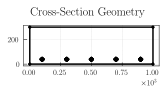

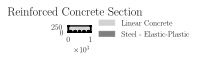

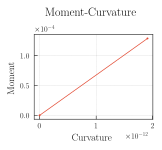

<Axes: title={'center': 'Moment-Curvature'}, xlabel='Curvature', ylabel='Moment'>

In [74]:
# | echo: false

from sectionproperties.pre.library import circular_section, rectangular_section

import concreteproperties.stress_strain_profile as ssp
from concreteproperties import (
    Concrete,
    ConcreteSection,
    SteelBar,
    add_bar_rectangular_array,
)
from concreteproperties.results import MomentCurvatureResults


conc_linear = Concrete(
    name="Linear Concrete",
    density=2.4e-6,
    stress_strain_profile=ssp.ConcreteServiceProfile(
        strains=[0, (f_c / E_c).to(un.los), varepsilon_cu.to(un.los).m],
        stresses=[0, f_c.m, f_c.m],
        ultimate_strain=0.005,
    ),
    ultimate_stress_strain_profile=ssp.BilinearStressStrain(
        compressive_strength=f_c.m,
        compressive_strain=0.0025,
        ultimate_strain=0.005,
    ),
    flexural_tensile_strength=0.0,
    colour="lightgrey",
)

conc_linear.stress_strain_profile

# B500a Spannungs-Dehnungs-beziehung

b500a = SteelBar(
    name="Steel - Elastic-Plastic",
    density=7.85e-6,
    stress_strain_profile=ssp.SteelProfile(
        strains=[0, varepsilon_sy_com_A.to(un.los).m, varepsilon_su_com_A.to(un.los).m],
        stresses=[
            0,
            f_sy_com_A.m,
            f_su_com_A.m,
        ],
        yield_strength=f_sy_com_A.m,
        elastic_modulus=E_s_com_A.to(un.N / un.mm**2).m,
        fracture_strain=varepsilon_su_com_A.to(un.los).m,
    ),
    colour="grey",
)

b500a.stress_strain_profile

# Querschnitt erstellen
col = rectangular_section(d=h.m, b=b_w.to(un.mm).m)

# add bars to column
geom_b500a = add_bar_rectangular_array(
    geometry=col,
    area=(diam_x **2 / 4 * np.pi).m,
    material=b500a,
    n_x=int(b_w / s_x),
    x_s=s_x.m,
    n_y=1,
    y_s=100,
    anchor=(s_x.m / 2, (c + diam_y + diam_x / 2).m),
    exterior_only=True,
)

geom_b500a.plot_geometry(labels=[], cp=False, legend=False)


# Adding the materials to the section

# assign concrete material to first geometry in CompoundGeometry object
geom_b500a.geoms[0].material = conc_linear

# create ConcreteSection object
conc_sec = ConcreteSection(geom_b500a)
conc_sec.plot_section()

res = conc_sec.moment_curvature_analysis(
        theta=0, kappa_inc=2.5e-7, progress_bar=False
    )
res.plot_results()

